In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Front-facing Full-shot Image Detection

### stage 1 

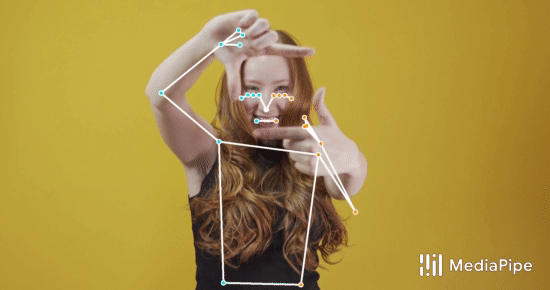

<b>MediaPipe</b> Pose is a ML solution for high-fidelity body pose tracking, inferring 33 3D landmarks on the whole body (or 25 upper-body landmarks) from RGB video frames utilizing our BlazePose research that also powers the ML Kit Pose Detection API. Current state-of-the-art approaches rely primarily on powerful desktop environments for inference, whereas this method achieves real-time performance on most modern mobile phones, desktops/laptops, in python and even on the web.

### https://google.github.io/mediapipe/solutions/pose.html

#Resources

### https://ai.googleblog.com/2020/08/on-device-real-time-body-pose-tracking.html

### https://arxiv.org/pdf/2006.10204.pdf

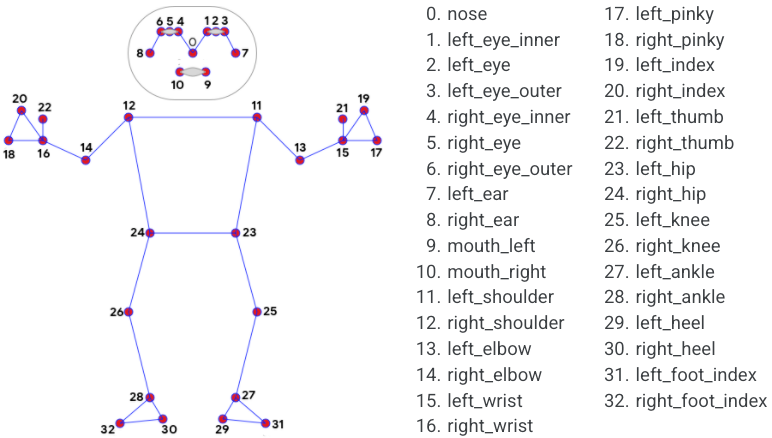

In [ ]:
pip install mediapipe

     |████████████████████████████████| 47.4MB 85kB/s 


In [ ]:
#importing relevent pakages
import cv2
import mediapipe as mp  #mediapipe model for pose detection
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  
import os
import json
from tqdm.notebook import tqdm_notebook # for viewing progress bar 
import pandas as pd
from random import sample

In [ ]:
def full_pose(results):
    """
  idea: if an image contains nose , left and right ankle 
  then the image might be a full-shot image
  Full-shot image is complete image

  we will use 0.6 as our thershold
  i.e. if model thinks there is 20% chance that all nose, left and right ankle are present 
  we will mark that image as full shot

    """
    if results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ANKLE].visibility > 0.6 and results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ANKLE].visibility > 0.6  and results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].visibility >0.6 :
        return True
    else:
        return False

In [ ]:
path='/content/dataset'
files=os.listdir(path+'/image')  # iamges names
annos=os.listdir(path+'/annos')  # json names

In [ ]:
def only_item(json_load):
  """
  since json contains many information such as zoom_in ,occlusion , viewpoint etc
  here we will extract relevent information i.e bounding , category_id and category_name
  
  """
  dictionary=dict()
    for key in json_load.keys():
    if 'item' in key:
        dictionary[key]={'bounding_box':json_load[key]['bounding_box'],
                       'category_id':json_load[key]['category_id'],
                       'category_name':json_load[key]['category_name']}
    return dictionary

In [ ]:
# updating Json 
for ann in annos:
    with open(path+'/annos/'+ann) as f:
        data = json.load(f)
        data=only_item(data)
        os.remove(path+'/annos/'+ann) # removing previous json
    with open(path+'/annos/'+ann, 'w') as f:  # adding new json
        json.dump(data, f, indent=4)

In [ ]:
# initializing blaze pose model 
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

#Visualizing Blaze pose performance


# Pose detection on some randomly selected images

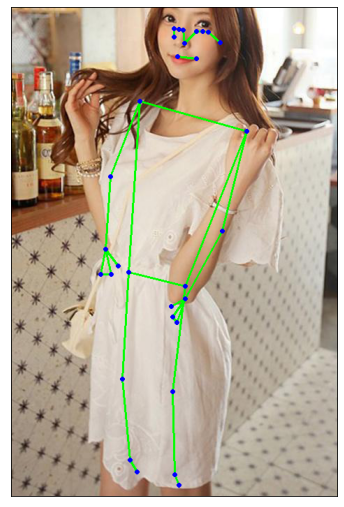

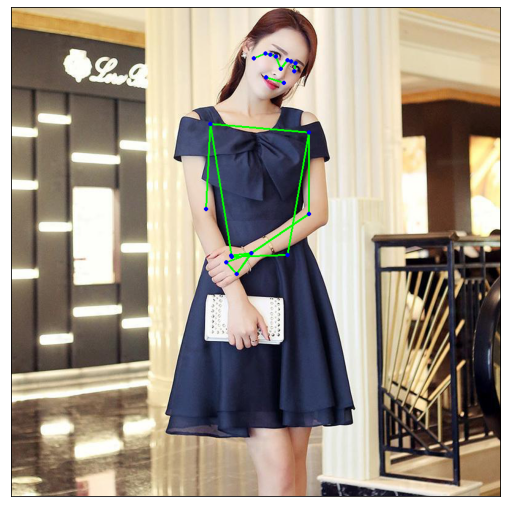

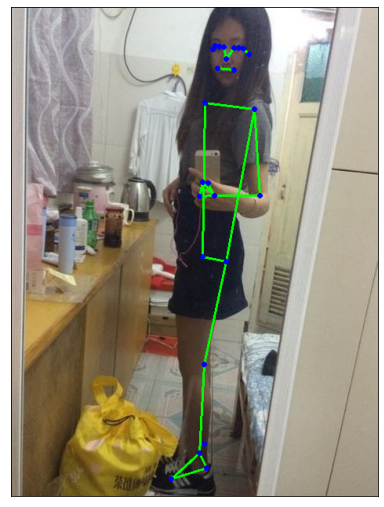

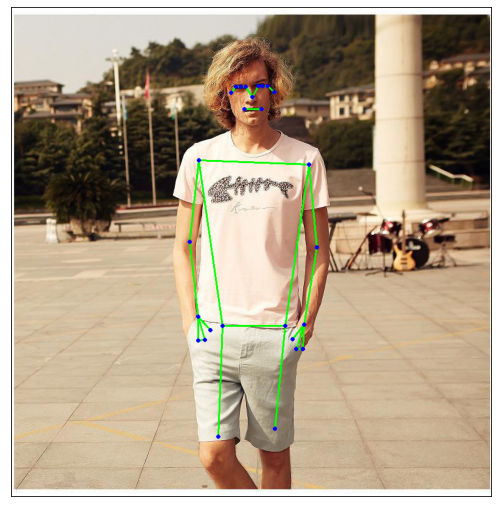

In [ ]:
## applying pose detection on all images
### code is inspired from https://google.github.io/mediapipe/solutions/pose.html
random_files=sample(files,10)
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose: # loading model
    for file in random_files:   #iterating overfiles
        image = mpimg.imread(path+'/image/'+file) # reading file
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) #processing image
        if results.pose_landmarks is None: # sometime model returns None therefore ignoring those images
            continue
        annotated_image = image.copy()
        # Use mp_pose.UPPER_BODY_POSE_CONNECTIONS for drawing below when
        # upper_body_only is set to True.
        mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        plt.figure(figsize=(9,9))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(annotated_image)
        plt.show()

# Checking model outputs (is full pose ?) on few randomly selected images

### full-Pose images --- classified by model

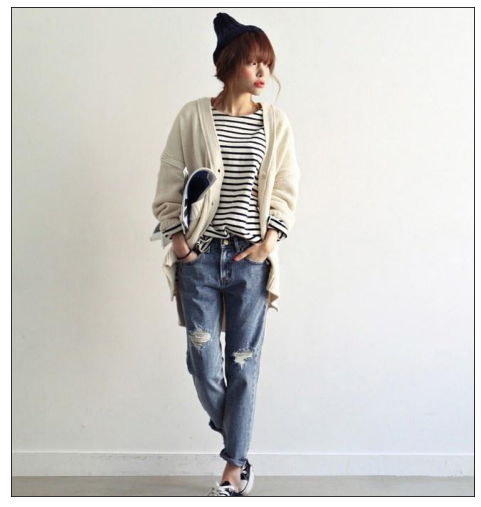

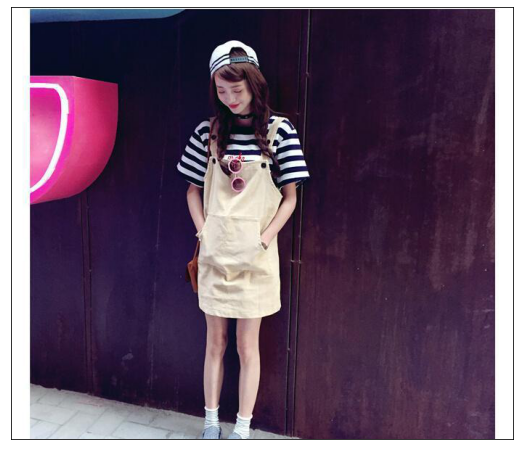

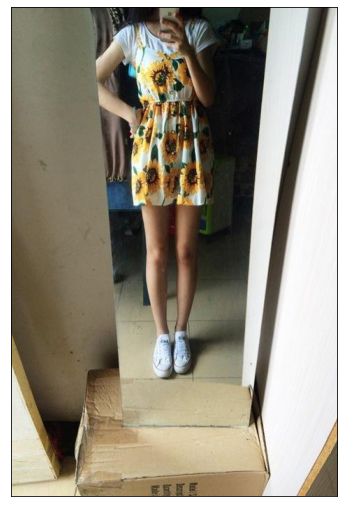

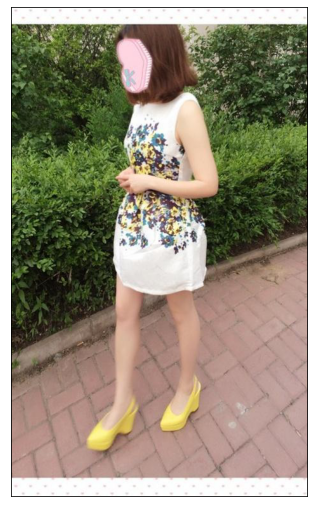

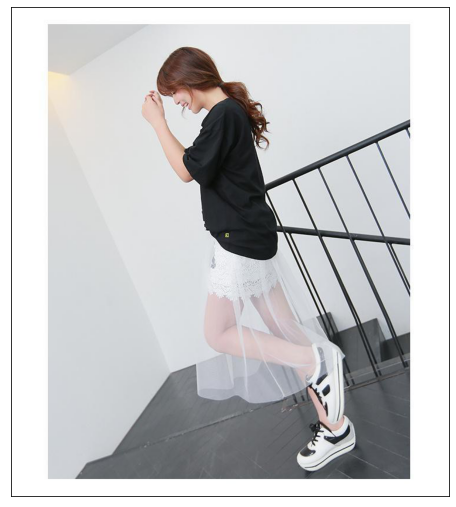

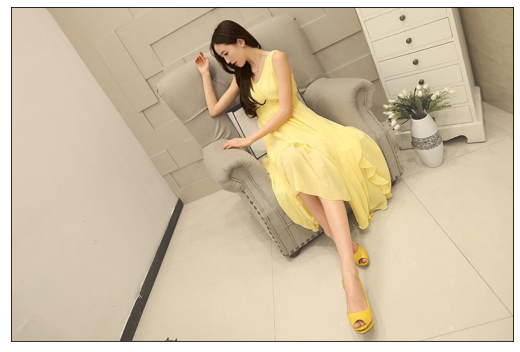

In [ ]:
## applying full shot detection on all images
### code is inspired from https://google.github.io/mediapipe/solutions/pose.html
random_files=sample(files,30)
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose: # loading model
    for file in random_files:   #iterating overfiles
        image = mpimg.imread(path+'/image/'+file) # reading file
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) #processing image
    if results.pose_landmarks is None: # sometime model returns None therefore ignoring those images
        continue
    if full_pose(results): # if image predicts it is not full-shot ignoring that image
        plt.figure(figsize=(9,9))
        plt.axis('off')
        plt.imshow(image)
        plt.show()

## Not a Full pose --- classified by model


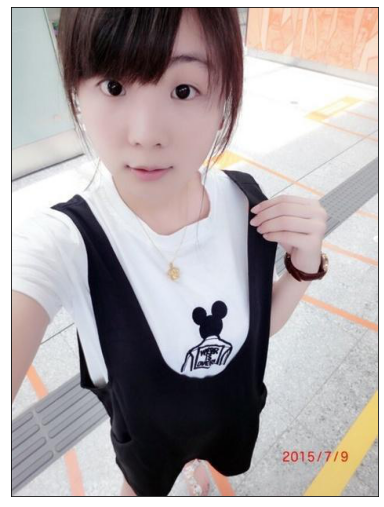

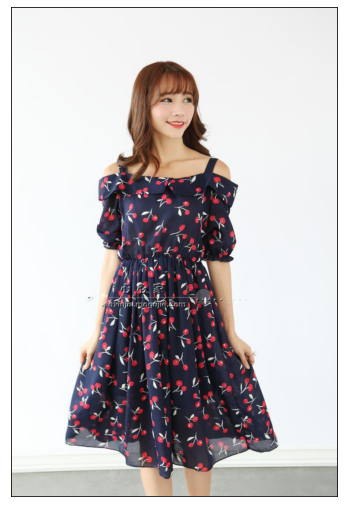

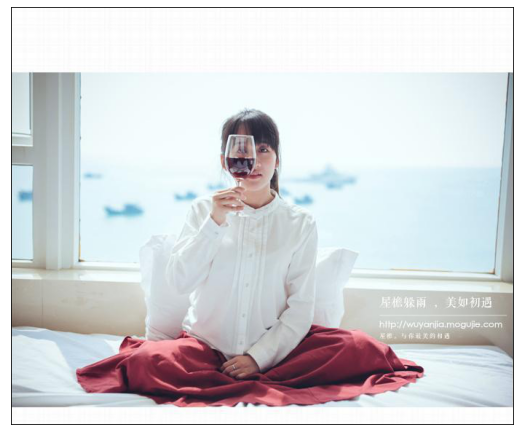

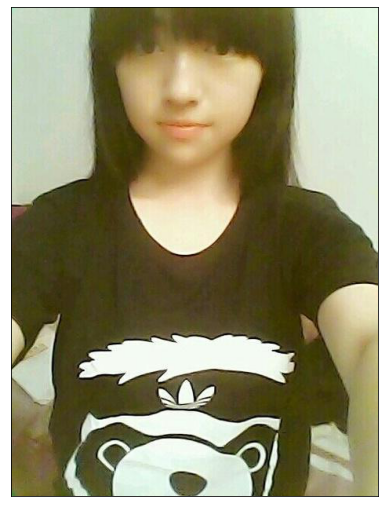

In [ ]:
## applying full shot detection on all images
### code is inspired from https://google.github.io/mediapipe/solutions/pose.html
random_files=sample(files,15)
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose: # loading model
    for file in random_files:   #iterating overfiles
        image = mpimg.imread(path+'/image/'+file) # reading file
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) #processing image
    if results.pose_landmarks is None: # sometime model returns None therefore ignoring those images
        continue
    if not full_pose(results): # if image predicts it is not full-shot ignoring that imge
        plt.figure(figsize=(9,9))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
        plt.show()

# we can see model performs very impressive on the dataset.

# It can very correctly classifiy whether an image is full-shot or not

In [ ]:
## applying full shot detection on all images
### code is inspired from https://google.github.io/mediapipe/solutions/pose.html
temp_list=[]
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose: # loading model
    for file in tqdm_notebook(files):   #iterating overfiles
        image = mpimg.imread(path+'/image/'+file) # reading file
        image_height, image_width, _ = image.shape 
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) #processing image
    if results.pose_landmarks is None: # sometime model returns None therefore ignoring those images
        os.remove(path+'/image/'+file)
        os.remove(path+'/annos/'+file.split('.')[0]+'.json')
        continue
    if not full_pose(results): # if image predicts it is not full-shot ignoring that imge
        os.remove(path+'/image/'+file)
        os.remove(path+'/annos/'+file.split('.')[0]+'.json')
        continue
    temp_list.append([file,image_height,image_width]) # storing full-shot images information
temp=pd.DataFrame(temp_list,columns=['id','height','width'])
temp.head()

id  height  width
0  020709.jpg     818    640
1  018679.jpg     702    468
2  026874.jpg     843    750
3  002321.jpg     400    300
4  013233.jpg    1156    750

### temp dataframe is used while preparing data for training of yolov4

## Thank you